In [1]:
!pip install gymnasium
!pip install pygame
!pip install matplotlib

# Implementación de SARSA para MountainCar

En este notebook implementamos el algoritmo SARSA para resolver el problema de MountainCar de Gymnasium. Este entorno consiste en un coche en un valle que debe alcanzar la cima de una colina. El coche no tiene suficiente potencia para escalar la colina directamente, así que debe usar el momentum generado al moverse hacia adelante y hacia atrás.

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.animation as animation
from IPython.display import HTML, display

# Parámetros globales
SEED = 42
ACCIONES = ['Izquierda', 'No empujar', 'Derecha']

# -------------------- DISCRETIZACIÓN --------------------

class Discretizador:
    """Clase para discretizar espacios continuos."""

    def __init__(self, env, nbins=(10, 10)):
        """
        Inicializa el discretizador.

        Args:
            env: Entorno de gymnasium
            nbins: Tupla con número de bins para cada dimensión
        """
        self.env = env
        self.nbins = nbins
        self.estados_discretos = np.prod(nbins)

        # Obtener límites de observación
        self.observation_space = env.observation_space
        self.low = self.observation_space.low
        self.high = self.observation_space.high

        # Ajustar límites para evitar casos límite
        self.low[0] = -1.2  # posición mínima
        self.high[0] = 0.6  # posición máxima
        self.low[1] = -0.07  # velocidad mínima
        self.high[1] = 0.07  # velocidad máxima

        print(f"Espacio de observación: {self.observation_space}")
        print(f"Límites inferiores ajustados: {self.low}")
        print(f"Límites superiores ajustados: {self.high}")
        print(f"Número de estados discretos: {self.estados_discretos}")

    def discretizar(self, obs):
        """
        Convierte una observación continua en un índice discreto.

        Args:
            obs: Observación continua del entorno

        Returns:
            int: Índice del estado discreto
        """
        # Ajustar las observaciones que estén fuera de los límites
        obs_ajustado = np.clip(obs, self.low, self.high)

        # Discretizar cada dimensión
        escalados = (obs_ajustado - self.low) / (self.high - self.low)
        indices = np.floor(escalados * self.nbins).astype(int)

        # Asegurarse de que los índices están dentro del rango
        indices = np.clip(indices, 0, np.array(self.nbins) - 1)

        # Convertir los índices multidimensionales a un índice único
        idx = indices[0]
        for i in range(1, len(indices)):
            idx = idx * self.nbins[i] + indices[i]

        return idx

# -------------------- POLÍTICAS --------------------

def epsilon_soft_policy(Q: np.ndarray, epsilon: float, state: int, nA: int) -> np.ndarray:
    """Devuelve una política epsilon-soft como vector de probabilidades."""
    policy = np.ones(nA) * epsilon / nA
    best_action = np.argmax(Q[state])
    policy[best_action] += 1.0 - epsilon
    return policy

def seleccionar_accion(Q: np.ndarray, epsilon: float, state: int, nA: int) -> int:
    """Devuelve una acción siguiendo política epsilon-greedy."""
    policy = epsilon_soft_policy(Q, epsilon, state, nA)
    return np.random.choice(np.arange(nA), p=policy)

# -------------------- VISUALIZACIÓN DE POLÍTICA --------------------

def visualizar_trayectoria(env, agente, discretizador, max_pasos=200):
    """
    Visualiza una trayectoria del agente en el entorno.

    Args:
        env: Entorno de gymnasium
        agente: Agente entrenado
        discretizador: Discretizador para convertir observaciones continuas en estados discretos
        max_pasos: Número máximo de pasos a visualizar
    """
    state, _ = env.reset(seed=SEED)
    states = [state]
    done = False
    total_reward = 0
    pasos = 0

    while not done and pasos < max_pasos:
        state_idx = discretizador.discretizar(state)
        action = np.argmax(agente.Q[state_idx])
        state, reward, terminated, truncated, _ = env.step(action)
        states.append(state.copy())
        done = terminated or truncated
        total_reward += reward
        pasos += 1

    # Convertir la lista de estados a un array numpy
    states = np.array(states)

    # Graficar la trayectoria
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(states[:, 0], states[:, 1], 'b-', alpha=0.7)
    ax.scatter(states[0, 0], states[0, 1], color='g', s=100, label='Inicio')
    ax.scatter(states[-1, 0], states[-1, 1], color='r', s=100, label='Fin')

    ax.set_xlabel('Posición')
    ax.set_ylabel('Velocidad')
    ax.set_title(f'Trayectoria del agente (Recompensa: {total_reward:.2f}, Pasos: {pasos})')
    ax.legend()
    ax.grid(True)

    plt.show()

    return total_reward, pasos

def visualizar_politica(agente, discretizador):
    """
    Visualiza la política aprendida como un mapa de calor.

    Args:
        agente: Agente entrenado
        discretizador: Discretizador para convertir observaciones continuas en estados discretos
    """
    # Crear una malla para visualizar la política
    pos = np.linspace(discretizador.low[0], discretizador.high[0], discretizador.nbins[0])
    vel = np.linspace(discretizador.low[1], discretizador.high[1], discretizador.nbins[1])

    X, Y = np.meshgrid(pos, vel)
    Z = np.zeros_like(X)

    # Para cada punto de la malla, determinar la mejor acción
    for i in range(len(pos)):
        for j in range(len(vel)):
            state = np.array([pos[i], vel[j]])
            state_idx = discretizador.discretizar(state)
            Z[j, i] = np.argmax(agente.Q[state_idx])

    # Graficar el mapa de calor
    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = plt.cm.viridis
    im = ax.imshow(Z, cmap=cmap, extent=[discretizador.low[0], discretizador.high[0],
                                         discretizador.low[1], discretizador.high[1]],
                   aspect='auto', origin='lower')

    # Añadir etiquetas y título
    ax.set_xlabel('Posición')
    ax.set_ylabel('Velocidad')
    ax.set_title('Política óptima (0=Izquierda, 1=No empujar, 2=Derecha)')

    # Añadir una leyenda de color
    cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2])
    cbar.set_label('Acción')
    cbar.set_ticklabels(['Izquierda', 'No empujar', 'Derecha'])

    plt.show()

def animar_episodio(env, agente, discretizador, max_pasos=200, intervalo=50):
    """
    Crea una animación de un episodio.

    Args:
        env: Entorno de gymnasium
        agente: Agente entrenado
        discretizador: Discretizador para convertir observaciones continuas en estados discretos
        max_pasos: Número máximo de pasos a visualizar
        intervalo: Intervalo entre frames en milisegundos
    """
    env_render = gym.make("MountainCar-v0", render_mode="rgb_array")
    state, _ = env_render.reset(seed=SEED)
    frames = []

    done = False
    pasos = 0

    while not done and pasos < max_pasos:
        frames.append(env_render.render())
        state_idx = discretizador.discretizar(state)
        action = np.argmax(agente.Q[state_idx])
        state, _, terminated, truncated, _ = env_render.step(action)
        done = terminated or truncated
        pasos += 1

    # Crear la animación
    fig, ax = plt.subplots(figsize=(8, 6))
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        return [patch]

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=intervalo)
    plt.close() # Para evitar que se muestre la figura vacía

    return HTML(anim.to_jshtml())

# -------------------- MÉTRICAS Y RESULTADOS --------------------

def graficar_recompensas(agente):
    """Grafica la tendencia de recompensas por episodio."""
    plt.figure(figsize=(10, 6))
    plt.plot(agente.stats, 'b-', alpha=0.7)
    plt.title('Recompensa promedio por episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa promedio')
    plt.grid(True)
    plt.show()

def graficar_longitud_episodios(agente):
    """Grafica la longitud de cada episodio."""
    ventana = min(100, len(agente.episode_lengths))
    medias_moviles = pd.Series(agente.episode_lengths).rolling(window=ventana).mean()

    plt.figure(figsize=(10, 6))
    plt.plot(agente.episode_lengths, 'b-', alpha=0.3, label='Longitud')
    plt.plot(medias_moviles, 'r-', label=f'Media móvil ({ventana} episodios)')
    plt.title("Longitud por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Longitud")
    plt.legend()
    plt.grid(True)
    plt.show()

def mostrar_resultados_agente(agente, discretizador, env):
    """Muestra visualizaciones y métricas del agente."""
    graficar_recompensas(agente)
    graficar_longitud_episodios(agente)

    print("\nVisualización de la política aprendida:")
    visualizar_politica(agente, discretizador)

    print("\nTrayectoria del agente usando la política aprendida:")
    total_reward, pasos = visualizar_trayectoria(env, agente, discretizador)
    print(f"Recompensa total: {total_reward}, Pasos: {pasos}")

    print("\nAnimación del episodio:")
    display(animar_episodio(env, agente, discretizador))

# Agente SARSA para espacios de estado continuos

En esta sección implementamos una versión de SARSA adaptada para trabajar con el espacio continuo de MountainCar.
La adaptación principal consiste en discretizar el espacio de estados para poder usar una tabla Q.

In [ ]:
class AgenteSARSA:
    def __init__(self, env, discretizador, epsilon=1.0, alpha=0.1, discount_factor=1.0, decay=True):
        self.env = env
        self.discretizador = discretizador
        self.epsilon = epsilon
        self.alpha = alpha
        self.discount_factor = discount_factor
        self.decay = decay
        self.nA = env.action_space.n
        self.Q = np.zeros([discretizador.estados_discretos, self.nA])
        self.stats = []
        self.episode_lengths = []
        self.solved_episodes = 0  # Contador de episodios resueltos

    def entrenar(self, num_episodes=10000, mostrar_barra=True):
        random.seed(SEED)
        np.random.seed(SEED)
        
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            state, _ = self.env.reset()
            state_idx = self.discretizador.discretizar(state)
            done = False

            if self.decay:
                self.epsilon = max(0.01, min(1.0, 1.0 / (0.01 * t + 1)))

            action = seleccionar_accion(self.Q, self.epsilon, state_idx, self.nA)
            total_reward = 0
            pasos = 0
            max_height = -1.2  # Seguimiento de la altura máxima alcanzada

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                next_state_idx = self.discretizador.discretizar(next_state)
                done = terminated or truncated
                pasos += 1
                
                # Seguimiento de la altura máxima
                max_height = max(max_height, next_state[0])
                
                # Recompensa modificada para acelerar el aprendizaje
                # 1. Bonus por llegar a la meta
                if terminated and next_state[0] >= 0.5:
                    reward = 10.0
                    self.solved_episodes += 1
                # 2. Recompensa por altura - incentiva subir la colina
                else:
                    # Recompensa proporcional a la altura actual
                    reward = reward + (next_state[0] + 1.2) / 1.8
                    
                    # Penalización por quedarse quieto
                    if abs(next_state[1]) < 0.001:  # velocidad cercana a cero
                        reward -= 0.1
                    
                    # Recompensa por velocidad en la dirección correcta
                    if next_state[0] < -0.5 and next_state[1] < 0:  # Moverse a la izquierda en la parte izquierda
                        reward += 0.1
                    elif next_state[0] > -0.5 and next_state[1] > 0:  # Moverse a la derecha en la parte derecha
                        reward += 0.1
                
                total_reward += reward

                if not done:
                    next_action = seleccionar_accion(self.Q, self.epsilon, next_state_idx, self.nA)
                    td_target = reward + self.discount_factor * self.Q[next_state_idx, next_action]
                else:
                    td_target = reward  # no hay estado siguiente

                td_error = td_target - self.Q[state_idx, action]
                self.Q[state_idx, action] += self.alpha * td_error

                state_idx = next_state_idx
                action = next_action if not done else None

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(total_reward)  # Guardamos la recompensa del episodio
            
            # Imprimir progreso periódicamente
            if t % 1000 == 0 and t > 0:
                solved_rate = self.solved_episodes / (t + 1)
                print(f"Episodio {t}: Recompensa={total_reward:.2f}, Pasos={pasos}, " +
                      f"Max altura={max_height:.2f}, Tasa de éxito={solved_rate:.2%}")

        return self.Q

# Grid Search para encontrar los mejores hiperparámetros

Buscaremos los mejores hiperparámetros para MountainCar.

In [ ]:
def evaluar_configuracion(params):
    env = gym.make("MountainCar-v0")
    env.reset(seed=SEED)
    
    num_bins = (12, 12)  # Aumentamos la resolución para mejor rendimiento
    discretizador = Discretizador(env, num_bins)
    
    alpha, gamma, epsilon, decay = params
    agente = AgenteSARSA(env, discretizador, alpha=alpha, epsilon=epsilon, discount_factor=gamma, decay=decay)
    agente.entrenar(num_episodes=2000, mostrar_barra=False)  # Aumentamos episodios para evaluación
    
    # Evaluamos el agente con epsilon=0 (política greedy)
    env_eval = gym.make("MountainCar-v0")
    eval_episodes = 20  # Más episodios para una evaluación más robusta
    total_reward = 0
    pasos_totales = 0
    exitos = 0
    
    for _ in range(eval_episodes):
        state, _ = env_eval.reset(seed=SEED+_ )  # Semillas diferentes para diversidad
        done = False
        ep_reward = 0
        pasos = 0
        
        while not done:
            state_idx = discretizador.discretizar(state)
            action = np.argmax(agente.Q[state_idx])
            state, reward, terminated, truncated, _ = env_eval.step(action)
            done = terminated or truncated
            ep_reward += reward
            pasos += 1
            
            # Limitamos los pasos para evitar episodios infinitos
            if pasos >= 500:  # Reducimos el límite para ser más exigentes
                break
                
            # Registrar éxito si llega a la meta
            if terminated and state[0] >= 0.5:
                exitos += 1
        
        total_reward += ep_reward
        pasos_totales += pasos
    
    recompensa_media = total_reward / eval_episodes
    pasos_medios = pasos_totales / eval_episodes
    tasa_exito = exitos / eval_episodes
    
    # La puntuación ahora considera también la tasa de éxito
    puntuacion = recompensa_media + tasa_exito * 200 - (pasos_medios / 200)
    
    return (alpha, gamma, epsilon, decay, puntuacion, recompensa_media, pasos_medios, tasa_exito)

def grid_search():
    # Espacio de búsqueda optimizado para MountainCar
    alphas = [0.1, 0.2, 0.3, 0.5]
    gammas = [0.95, 0.99, 1.0]  # Enfoque en factores de descuento altos
    epsilons = [0.1, 0.3, 1.0]  # Menos valores de epsilon para reducir el espacio de búsqueda
    
    # Combinaciones con decay = False (usar epsilon fijo)
    combinaciones_sin_decay = [(a, g, e, False) for a, g, e in product(alphas, gammas, epsilons)]
    
    # Combinaciones con decay = True (epsilon se reduce con el tiempo)
    combinaciones_con_decay = [(a, g, 1.0, True) for a, g in product(alphas, gammas)]
    
    # Unir ambas listas
    combinaciones = combinaciones_sin_decay + combinaciones_con_decay

    mejor_config = None
    mejor_puntuacion = -float('inf')
    resultados = []

    print("🔍 Buscando la mejor combinación de hiperparámetros...\n")

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(evaluar_configuracion, combo) for combo in combinaciones]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Progreso"):
            alpha, gamma, epsilon, decay_flag, puntuacion, recompensa, pasos, tasa_exito = future.result()
            resultados.append((alpha, gamma, epsilon, decay_flag, puntuacion, recompensa, pasos, tasa_exito))

            if puntuacion > mejor_puntuacion:
                mejor_puntuacion = puntuacion
                mejor_config = (alpha, gamma, epsilon, decay_flag, recompensa, pasos, tasa_exito)
    
    print("\n✅ Mejor configuración encontrada:")
    print(f" alpha = {mejor_config[0]}, γ = {mejor_config[1]}, ε = {mejor_config[2]}, decay = {mejor_config[3]}")
    print(f"  → Recompensa media: {mejor_config[4]:.2f}, Pasos medios: {mejor_config[5]:.1f}")
    print(f"  → Tasa de éxito: {mejor_config[6]:.2%}")
    
    return mejor_config

# Entrenamiento y evaluación del agente

Primero buscaremos los mejores hiperparámetros y luego entrenaremos un agente con esos valores.

In [5]:
# Realizar búsqueda de hiperparámetros (esto puede llevar tiempo)
mejor_config = grid_search()

# Extraer los mejores hiperparámetros encontrados
mejor_alpha = mejor_config[0]
mejor_gamma = mejor_config[1]
mejor_epsilon = mejor_config[2]
usar_decay = mejor_config[3]

print(f"\nUsando los mejores hiperparámetros encontrados:")
print(f"alpha={mejor_alpha}, gamma={mejor_gamma}, epsilon={mejor_epsilon}, decay={usar_decay}")

# También podemos examinar la recompensa media y los pasos medios de la mejor configuración
mejor_recompensa = mejor_config[4]
mejor_pasos = mejor_config[5]
print(f"Esta configuración logró una recompensa media de {mejor_recompensa:.2f} y {mejor_pasos:.1f} pasos en promedio.")

🔍 Buscando la mejor combinación de hiperparámetros...



Progreso:   0%|          | 0/80 [00:00<?, ?it/s]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]

Número de estados discretos: 100Límites inferiores ajustados: [-1.2  -0.07]

Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:   1%|▏         | 1/80 [00:42<55:45, 42.34s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:   2%|▎         | 2/80 [00:43<23:27, 18.05s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:   4%|▍         | 3/80 [01:16<31:59, 24.93s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:   5%|▌         | 4/80 [01:17<19:43, 15.57s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:   6%|▋         | 5/80 [01:49<26:50, 21.47s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:   8%|▊         | 6/80 [01:53<18:57, 15.38s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:   9%|▉         | 7/80 [02:24<25:12, 20.71s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  10%|█         | 8/80 [02:28<18:09, 15.14s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  11%|█▏        | 9/80 [02:57<23:06, 19.53s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  12%|█▎        | 10/80 [03:03<18:07, 15.53s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  14%|█▍        | 11/80 [03:31<22:01, 19.16s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  15%|█▌        | 12/80 [03:36<16:55, 14.93s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  16%|█▋        | 13/80 [04:01<20:12, 18.10s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  18%|█▊        | 14/80 [04:10<16:46, 15.25s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  19%|█▉        | 15/80 [04:34<19:22, 17.88s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  20%|██        | 16/80 [04:43<16:14, 15.23s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  21%|██▏       | 17/80 [05:09<19:12, 18.30s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  22%|██▎       | 18/80 [05:16<15:29, 14.99s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  24%|██▍       | 19/80 [05:41<18:28, 18.17s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  25%|██▌       | 20/80 [05:50<15:21, 15.36s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  26%|██▋       | 21/80 [06:16<18:13, 18.54s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  28%|██▊       | 22/80 [06:23<14:36, 15.11s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  29%|██▉       | 23/80 [06:49<17:21, 18.28s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  30%|███       | 24/80 [06:58<14:21, 15.39s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  31%|███▏      | 25/80 [07:21<16:25, 17.92s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  32%|███▎      | 26/80 [07:30<13:42, 15.23s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  34%|███▍      | 27/80 [07:56<16:19, 18.48s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  35%|███▌      | 28/80 [08:06<13:36, 15.69s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  36%|███▋      | 29/80 [08:29<15:21, 18.06s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  38%|███▊      | 30/80 [08:41<13:31, 16.23s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  39%|███▉      | 31/80 [09:06<15:15, 18.69s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  40%|████      | 32/80 [09:14<12:27, 15.57s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  41%|████▏     | 33/80 [09:38<14:15, 18.19s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  42%|████▎     | 34/80 [09:48<12:00, 15.66s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  44%|████▍     | 35/80 [10:12<13:33, 18.09s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  45%|████▌     | 36/80 [10:20<11:12, 15.29s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  46%|████▋     | 37/80 [10:46<13:09, 18.36s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  48%|████▊     | 38/80 [10:56<11:02, 15.78s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  49%|████▉     | 39/80 [11:19<12:13, 17.88s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  50%|█████     | 40/80 [11:29<10:24, 15.61s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  51%|█████▏    | 41/80 [11:53<11:43, 18.03s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  52%|█████▎    | 42/80 [12:03<09:59, 15.79s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  54%|█████▍    | 43/80 [12:25<10:49, 17.55s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  55%|█████▌    | 44/80 [12:36<09:21, 15.59s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  56%|█████▋    | 45/80 [12:58<10:16, 17.62s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  57%|█████▊    | 46/80 [13:08<08:44, 15.43s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  59%|█████▉    | 47/80 [13:31<09:41, 17.62s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  60%|██████    | 48/80 [13:42<08:22, 15.69s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  61%|██████▏   | 49/80 [14:04<09:00, 17.42s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  62%|██████▎   | 50/80 [14:17<08:06, 16.22s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  64%|██████▍   | 51/80 [14:41<08:53, 18.41s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  65%|██████▌   | 52/80 [14:52<07:33, 16.19s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  66%|██████▋   | 53/80 [15:15<08:16, 18.40s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  68%|██████▊   | 54/80 [15:24<06:46, 15.62s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  69%|██████▉   | 55/80 [15:49<07:36, 18.25s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  70%|███████   | 56/80 [15:59<06:18, 15.77s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  71%|███████▏  | 57/80 [16:22<06:57, 18.14s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  72%|███████▎  | 58/80 [16:32<05:40, 15.48s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  74%|███████▍  | 59/80 [16:56<06:21, 18.16s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  75%|███████▌  | 60/80 [17:06<05:11, 15.59s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  76%|███████▋  | 61/80 [17:29<05:38, 17.81s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  78%|███████▊  | 62/80 [17:39<04:37, 15.40s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  79%|███████▉  | 63/80 [18:05<05:15, 18.59s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  80%|████████  | 64/80 [18:13<04:06, 15.41s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  81%|████████▏ | 65/80 [18:38<04:36, 18.42s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  82%|████████▎ | 66/80 [18:49<03:48, 16.30s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  84%|████████▍ | 67/80 [19:11<03:53, 17.99s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  85%|████████▌ | 68/80 [19:21<03:04, 15.40s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  86%|████████▋ | 69/80 [19:46<03:22, 18.40s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  88%|████████▊ | 70/80 [19:53<02:29, 14.97s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  89%|████████▉ | 71/80 [20:19<02:44, 18.23s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  90%|█████████ | 72/80 [20:28<02:03, 15.43s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  91%|█████████▏| 73/80 [20:53<02:09, 18.51s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  92%|█████████▎| 74/80 [21:01<01:31, 15.31s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  94%|█████████▍| 75/80 [21:27<01:31, 18.39s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  95%|█████████▌| 76/80 [21:37<01:03, 15.80s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  96%|█████████▋| 77/80 [22:03<00:56, 19.00s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso:  98%|█████████▊| 78/80 [22:11<00:31, 15.70s/it]

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 100


Progreso: 100%|██████████| 80/80 [22:41<00:00, 17.01s/it]


✅ Mejor configuración encontrada:
 alpha = 0.1, γ = 0.95, ε = 0.1, decay = False
  → Recompensa media: -139.00, Pasos medios: 139.0

Usando los mejores hiperparámetros encontrados:
alpha=0.1, gamma=0.95, epsilon=0.1, decay=False
Esta configuración logró una recompensa media de -139.00 y 139.0 pasos en promedio.


In [ ]:
# Crear y entrenar el agente con los mejores hiperparámetros
env = gym.make("MountainCar-v0")
env.reset(seed=SEED)

# Discretización con mayor resolución
num_bins = (16, 16)  # Aumentamos la resolución para capturar mejor las dinámicas
discretizador = Discretizador(env, num_bins)

# Crear y entrenar el agente
agente = AgenteSARSA(env, discretizador,
                     alpha=mejor_alpha,
                     discount_factor=mejor_gamma,
                     epsilon=mejor_epsilon,
                     decay=usar_decay)

# Entrenar durante más episodios para un mejor desempeño
print("Entrenando agente final con más episodios...")
agente.entrenar(num_episodes=20000)  # Duplicamos el número de episodios

# Verificar tasa de éxito al final del entrenamiento
tasa_exito = agente.solved_episodes / 20000
print(f"\nTasa de éxito final: {tasa_exito:.2%}")
print(f"El agente resolvió {agente.solved_episodes} de 20000 episodios")

Espacio de observación: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Límites inferiores ajustados: [-1.2  -0.07]
Límites superiores ajustados: [0.6  0.07]
Número de estados discretos: 144


100%|██████████| 10000/10000 [03:21<00:00, 49.53it/s]


array([[ -1.47363711,  -1.39944232,   0.        ],
       [-13.33258568, -13.98862164, -13.88346867],
       [-14.69619457, -14.66798274, -14.67090208],
       [-14.83935622, -14.84522787, -14.83350608],
       [-14.829857  , -14.66607092, -14.84362394],
       [-14.3241859 , -14.32407299, -14.24085675],
       [-13.60398292, -13.70799996, -13.32663084],
       [-12.33826577, -12.24317549, -12.1165195 ],
       [-10.86004789, -10.93173465, -10.94996154],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [-10.56099699, -10.41649131, -10.42066085],
       [-14.42977861, -14.67456872, -14.76379951],
       [-15.70062206, -15.67655108, -15.61609163],
       [-15.90745201, -16.00224948, -15.90342706],
       [-16.03875813, -15.8232617 , -15.77930579],
       [-15.85778684, -15.7335255 , -15.23236522],
       [-15.43295181, -14.00033376, -15.71378686],
       [-13.20624345, -13.27758

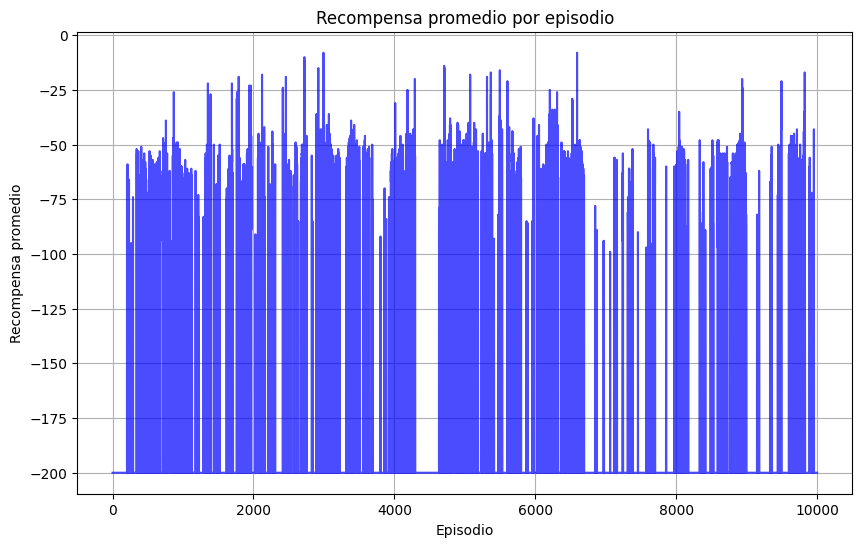

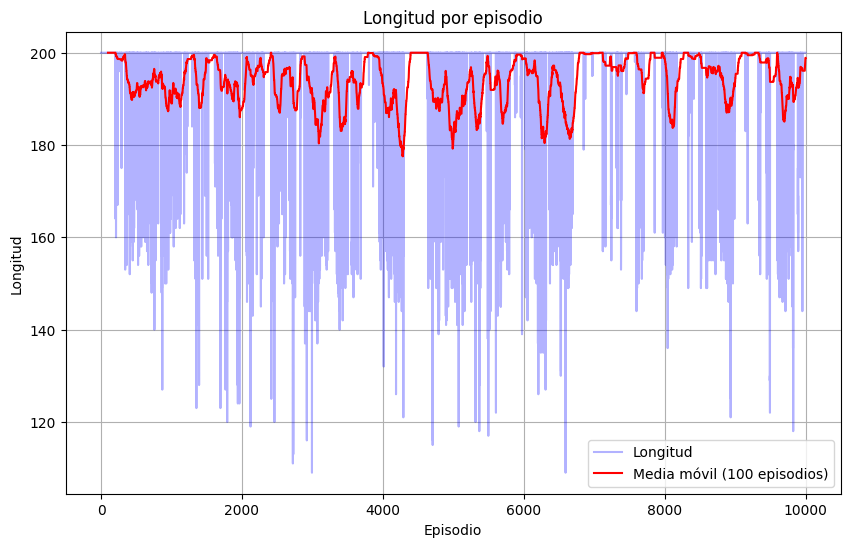


Visualización de la política aprendida:


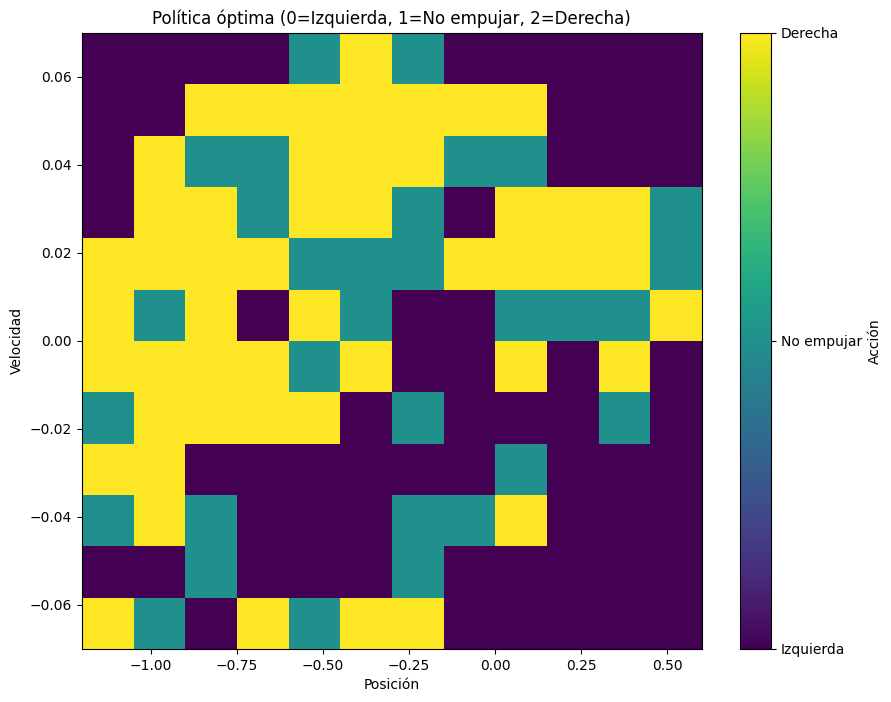


Trayectoria del agente usando la política aprendida:


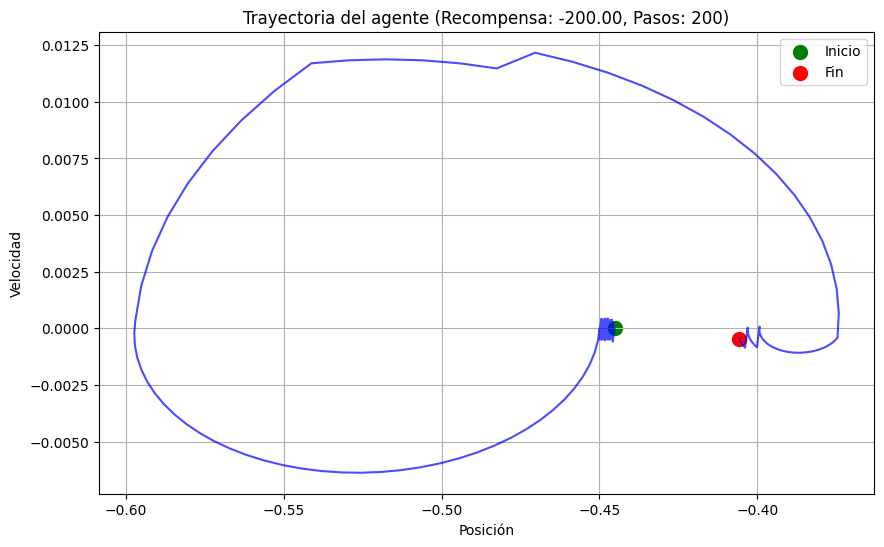

Recompensa total: -200.0, Pasos: 200

Animación del episodio:


In [7]:
# Visualizar resultados
mostrar_resultados_agente(agente, discretizador, env)